In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(DIRECTORY_OF_DATA)

In [3]:
import glob
import os

def delete_file():
    # Get a list of all HDF5 files in the current directory
    hdf5_files = glob.glob('*.hdf5')

    # Print each HDF5 file name
    for file in hdf5_files:
        os.remove(file)

    # Get a list of all JSON files in the current directory
    json_files = glob.glob('*.json')

    # Print each JSON file name
    for file in json_files:
        os.remove(file)
        
def get_latest_experiment_dir(base_dir):
        # Get a list of all items in the base directory
        items = os.listdir(base_dir)

        # Filter out items that are not directories
        dirs = [item for item in items if os.path.isdir(os.path.join(base_dir, item))]

        # Filter out directories that do not start with 'experiment_run'
        experiment_dirs = [dir for dir in dirs if dir.startswith('experiment_run')]

        # Sort the directories by the experiment number (the part after 'experiment_run')
        sorted_experiment_dirs = sorted(experiment_dirs, key=lambda dir: int(dir.split('_')[-1]) if dir.split('_')[-1].isdigit() else -1)

        # Return the last directory in the sorted list
        latest_dir = sorted_experiment_dirs[-1] if sorted_experiment_dirs else None
        
        # If latest_dir is None, raise an error
        if latest_dir is None:
            raise ValueError(f"No directories starting with 'experiment_run' found in {base_dir}")
        
        # Return the full path of the latest directory
        return os.path.join(base_dir, latest_dir).replace('\\', '/') if latest_dir else None

In [4]:
from sklearn.model_selection import train_test_split

def split_data(df):

    train_df, holdout_df = train_test_split(df, test_size=0.2, random_state=42)
            
    return train_df, holdout_df

In [5]:
from ludwig.api import LudwigModel
import requests
import yaml


# URL of the raw YAML file in the GitHub repository
def run_experiment(model_url, train_df, output_dir):
    
    # Send a GET request to the URL
    response = requests.get(model_url)

    # Raise an exception if the request was unsuccessful
    response.raise_for_status()

    # Load the YAML data from the response text
    config = yaml.safe_load(response.text)

    # Set up your experiment
    model = LudwigModel(config=config)
    experiment_results = model.experiment(
      dataset=train_df,
      output_directory=output_dir
    )
    return model


C:\Users\johna\anaconda3\envs\precision-recall-env\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
C:\Users\johna\anaconda3\envs\precision-recall-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def analysis(model, holdout_df):
    holdout_df = holdout_df.reset_index(drop=True)
    predictions, _ = model.predict(dataset=holdout_df)

    model_analysis_df = predictions.merge(right=holdout_df, left_index=True, right_index=True)
    model_analysis_df['Class_predictions'] = model_analysis_df['Class_predictions'].map({True: 1, False: 0})
    return model_analysis_df

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
import plotly.graph_objects as go
import numpy as np

def model_diagnostics(model_analysis_df, title):
    # Calculate Precision-Recall curve using probabilities
    precision, recall, thresholds = precision_recall_curve(model_analysis_df['Class'], model_analysis_df['Class_probabilities_True'])
    pr_auc = auc(recall, precision)

    # Calculate F1 scores for each threshold
    f1_scores = 2*(recall * precision) / (recall + precision)
    # Get index of the maximum F1 score
    max_f1_index = np.argmax(f1_scores)
    max_f1 = f1_scores[max_f1_index]
    max_precision = precision[max_f1_index]
    max_recall = recall[max_f1_index]

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(model_analysis_df['Class'], model_analysis_df['Class_probabilities_True'])
    roc_auc = roc_auc_score(model_analysis_df['Class'], model_analysis_df['Class_probabilities_True'])

    # Create the Precision-Recall curve
    pr_fig = go.Figure()
    pr_fig.add_trace(go.Scatter(x=recall, y=precision,
                             mode='lines',
                             name=f'PR curve (AUC = {pr_auc:.2f})'))

    # Mark the point with maximum F1 score
    pr_fig.add_trace(go.Scatter(x=[max_recall], y=[max_precision],
                             mode='markers',
                             marker=dict(color='Red', size=10),
                             name=f'Max F1 ({max_f1:.2f})'))

    # Add annotation for precision and recall at max F1 score
    pr_fig.add_annotation(x=max_recall, y=max_precision,
                       text=f'Precision: {max_precision:.2f}, Recall: {max_recall:.2f}',
                       showarrow=True,
                       arrowhead=1,
                       ax=0,
                       ay=-80)

    # Add random line
    no_skill = len(model_analysis_df['Class'][model_analysis_df['Class']==1]) / len(model_analysis_df['Class'])
    pr_fig.add_trace(go.Scatter(x=[0, 1], y=[no_skill, no_skill],
                             mode='lines', 
                             name='No Skill', 
                             line=dict(dash='dash')))

    pr_fig.update_xaxes(title_text="Recall")
    pr_fig.update_yaxes(title_text="Precision", range=[0, 1])
    pr_fig.update_layout(title_text=f'{title} - Precision Recall Curve', autosize=False)

    pr_fig.show()

    # Create ROC curve
    roc_fig = go.Figure()
    roc_fig.add_trace(go.Scatter(x=fpr, y=tpr,
                             mode='lines',
                             name=f'ROC curve (AUC = {roc_auc:.2f})'))

    # Add random line
    roc_fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1],
                             mode='lines', 
                             name='Random Classifier', 
                             line=dict(dash='dash')))

    roc_fig.update_xaxes(title_text="False Positive Rate")
    roc_fig.update_yaxes(title_text="True Positive Rate", range=[0, 1])
    roc_fig.update_layout(title_text=f'{title} - ROC Curve', autosize=False)

    roc_fig.show()

    # Return A


In [9]:
train_df , holdout_df = split_data(df)
model_url = 'https://raw.githubusercontent.com/john-adeojo/Credit-Card-Fraud-Model-Registry/main/model%20yaml%20files/synthetic_data/baseline_model.yaml'
output_dir = r"..\modelrun"
model = run_experiment(model_url, train_df, output_dir)
model_analysis_df = analysis(model, holdout_df)

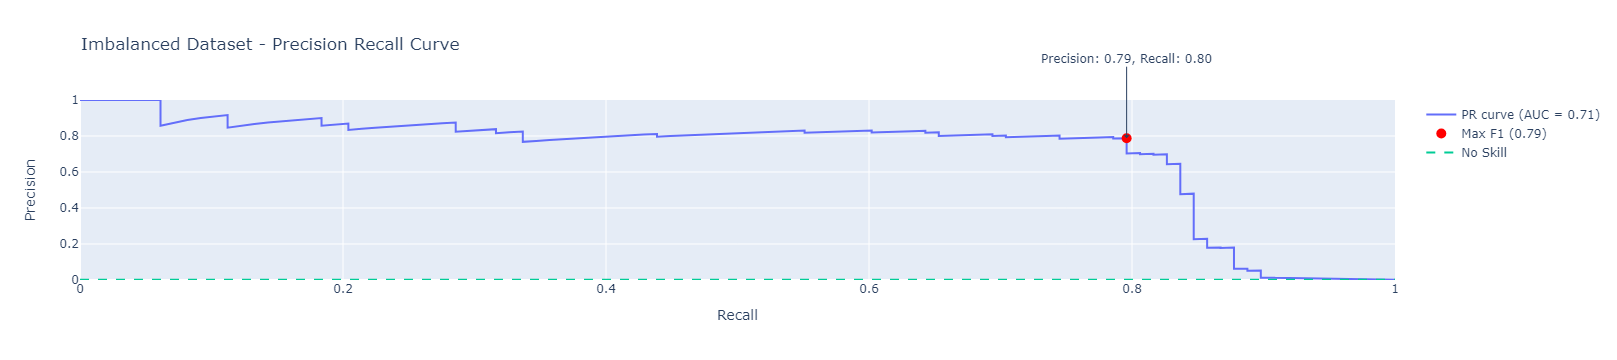

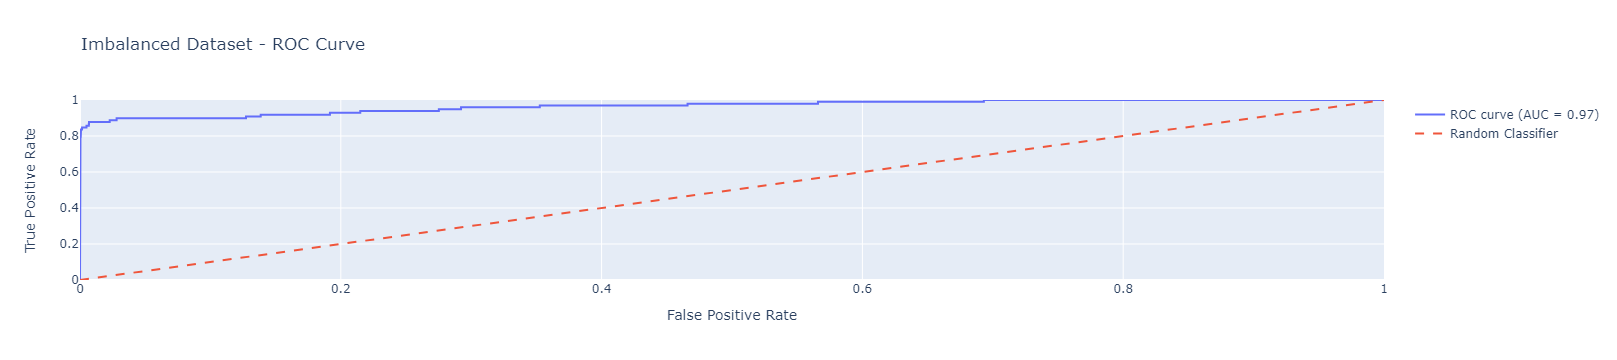

In [30]:
model_diagnostics(model_analysis_df, title="Imbalanced Dataset")
# delete_file()

In [27]:
from sklearn.utils import resample

# Separate the different classes
df_majority = model_analysis_df[model_analysis_df.Class==0]
df_minority = model_analysis_df[model_analysis_df.Class==1]

# Downsample the majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])


In [28]:
df_downsampled

Class_probabilities  Class_predictions  \
19599  [0.9999880157274674, 1.1984272532572504e-05]                  0   
41418  [0.9999932302648631, 6.7697351369133685e-06]                  0   
34763     [0.999610352300806, 0.000389647699194029]                  0   
4481    [0.9999649871970178, 3.501280298223719e-05]                  0   
27446   [0.9999913556002866, 8.644399713375606e-06]                  0   
...                                             ...                ...   
55799      [0.944567259401083, 0.05543274059891701]                  0   
56196     [0.08710652589797974, 0.9128934741020203]                  1   
56282      [0.2146950364112854, 0.7853049635887146]                  1   
56288     [0.23257160186767578, 0.7674283981323242]                  1   
56467      [0.3353450894355774, 0.6646549105644226]                  1   

       Class_probabilities_False  Class_probabilities_True  Class_probability  \
19599                   0.999988                  0.000012           0.999988   
41418                   0.999993                  0.000007           0.999993   
34763                   0.999610                  0.000390           0.999610   
4481                    0.999965                  0.000035           0.999965   
27446                   0.999991                  0.000009           0.999991   
...                          ...                       ...                ...   
55799                   0.944567                  0.055433           0.944567   
56196                   0.087107                  0.912893           0.912893   
56282                   0.214695                  0.785305           0.785305   
56288                   0.232572                  0.767428           0.767428   
56467                   0.335345                  0.664655           0.664655   

           Time         V1         V2         V3         V4  ...       V21  \
19599   70845.0  -1.132878   0.777117   1.234338   1.095589  ...  0.239899   
41418   48321.0   1.196288   0.090215   0.536234   0.847762  ... -0.209673   
34763  127594.0   1.705084   0.162441  -1.813428   3.465877  ...  0.084504   
4481    77996.0  -0.652263   0.533440   1.725238   0.854486  ...  0.373390   
27446   80140.0  -0.332602   1.138471   1.274430   0.047414  ... -0.268818   
...         ...        ...        ...        ...        ...  ...       ...   
55799   97121.0 -17.976266  12.864989 -19.575066  11.345120  ... -4.300432   
56196    8886.0  -2.535852   5.793644  -7.618463   6.395830  ...  0.716720   
56282  167338.0  -1.374424   2.793185  -4.346572   2.400731  ... -0.870779   
56288  133184.0  -1.212682  -2.484824  -6.397186   3.670562  ...  1.396872   
56467  154181.0  -0.549615   2.219075  -3.522024   0.236995  ...  0.364130   

            V22       V23       V24       V25       V26       V27       V28  \
19599  0.665532  0.234846 -0.274929 -0.546007 -0.373849 -0.168719 -0.169976   
41418 -0.416199 -0.016219  0.439244  0.480025  0.264399 -0.019545  0.018169   
34763 -0.265800 -0.030647  0.016665  0.102378 -0.059799 -0.119530 -0.045987   
4481   1.052172 -0.046815 -0.296924 -0.636518 -0.253741  0.092936  0.176819   
27446 -0.698578 -0.027589  0.278157 -0.153859  0.075404  0.246484  0.097549   
...         ...       ...       ...       ...       ...       ...       ...   
55799  2.865772  1.489302  0.386039 -0.232392  0.413827 -3.255981 -0.538963   
56196 -0.448060 -0.402407 -0.288835  1.011752  0.425965  0.413140  0.308205   
56282  0.504849  0.137994  0.368275  0.103137 -0.414209  0.454982  0.096711   
56288  0.092073 -1.492882 -0.204227  0.532511 -0.293871  0.212663  0.431095   
56467  0.210428 -0.366019  0.015803  0.349212  0.647302  0.171929  0.117188   

        Amount  Class  
19599     4.91      0  
41418    25.77      0  
34763   151.29      0  
4481     38.00      0  
27446     0.89      0  
...        ...    ...  
55799     8.64      1  
56196     1.00      1  
56282   349.08      1  
56288  1335.00      1  
56467     0.76      

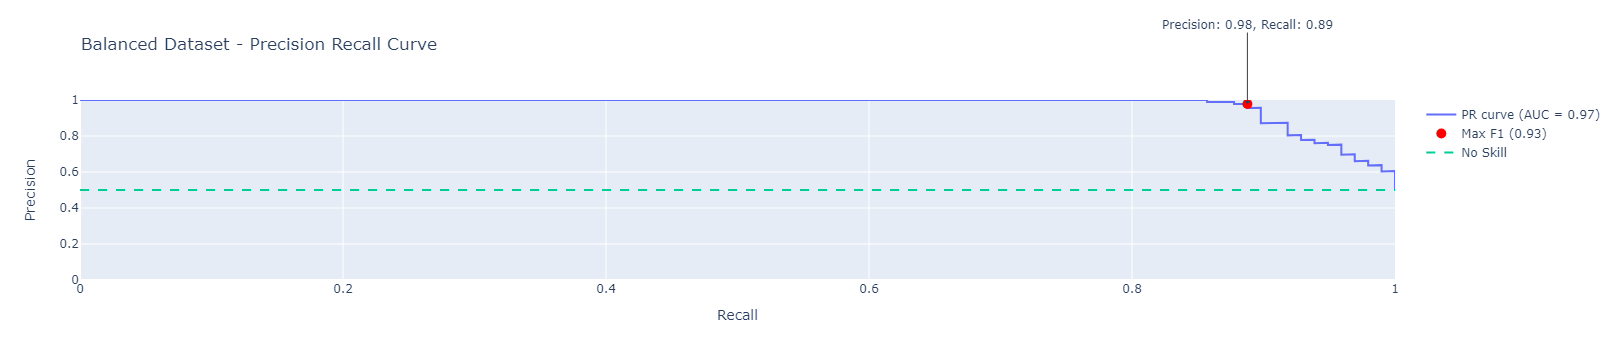

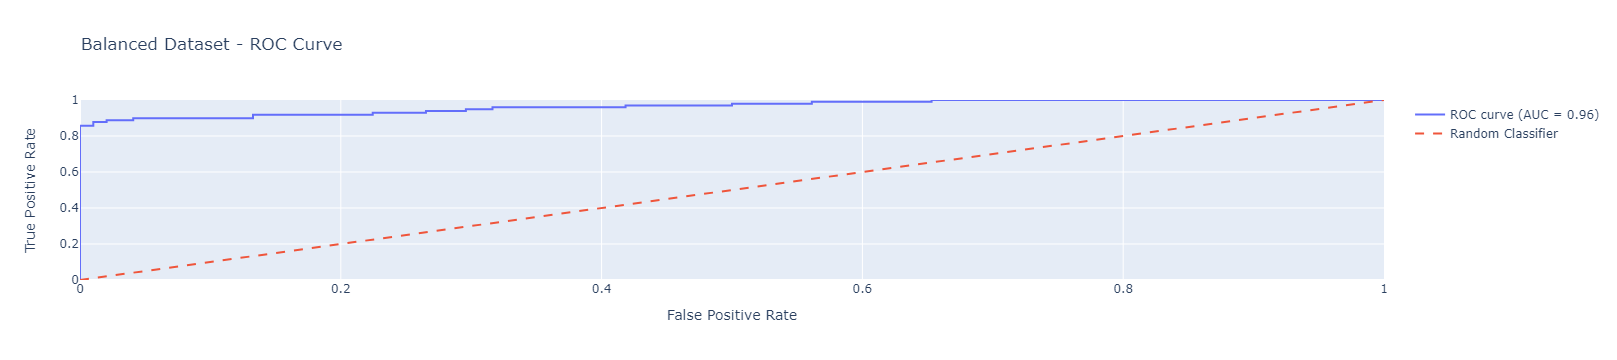

In [29]:
model_diagnostics(df_downsampled, title="Balanced Dataset")
